In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import calendar
import reverse_geocoder as rg
import collections
import seaborn as sns

plt.rcParams.update({'font.size': 10})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
data=pd.read_csv('feature.csv',parse_dates=['timestamp'])

In [3]:
# Assumption is that duplicated entries for the same time (hour) can be dropped
data.drop_duplicates(inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670208 entries, 0 to 676700
Data columns (total 5 columns):
timestamp    670208 non-null datetime64[ns]
user         670208 non-null object
sport        670208 non-null object
longitude    669958 non-null float64
latitude     669958 non-null float64
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 30.7+ MB


In [5]:
len(data.user.unique())

60201

In [6]:
data.head()

,timestamp,user,sport,longitude,latitude
0,2016-05-29 06:00:00,51663fe728afd0c03701845329190f7fe93c3a8ab2ff56...,hike,16.1,47.7
1,2016-08-15 19:00:00,08f0a9cb02168dce9544c7ce237eb2a291901a048bad24...,hike,12.0,47.7
2,2016-05-14 19:00:00,0762522db4b59efa5a11a535c88477d6c7a63972febdda...,hike,9.4,51.8
3,2017-06-12 20:00:00,70cc307f4148283217dadfcbff54eb9e7d7a944a0b57f6...,touringbicycle,7.8,48.0
4,2014-05-25 09:00:00,c1fc1e63e5e3875538ca23351954ed39405ec27b0c15bb...,mtb,6.8,50.6


### Step one: Add country based on location

 * Create auxiliary data frame to use for country lookup
 * Drop duplicated cooridnates to narrow the required search
 * Use reverse_geocoder as it doesn't limit the query - it is a library that uses KD trees to find nearest city over 1000 inhabitants. More can be found [here](https://github.com/thampiman/reverse-geocoder)
 * Geocoder retrieves the ISO2 codes that need to be transformed into country names
 * Use unique coordinates to map the location for full dataset

In [7]:
coordinates=data[data.longitude.notnull()|data.latitude.notnull()]
coordinates=coordinates[['longitude','latitude']]
coordinates.drop_duplicates(inplace=True)
coordinates.shape

(21342, 2)

In [8]:
coordinates['ISO2']=coordinates.apply(lambda row: rg.search((row['latitude'],row['longitude']))[0]['cc'],axis=1)

Loading formatted geocoded file...


In [10]:
coordinates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21342 entries, 0 to 676476
Data columns (total 3 columns):
latitude     21342 non-null float64
longitude    21342 non-null float64
ISO2         21342 non-null object
dtypes: float64(2), object(1)
memory usage: 666.9+ KB


In [12]:
coordinates['coordinates']=coordinates.longitude.astype(str)+coordinates.latitude.astype(str)

In [13]:
iso=pd.read_csv('iso.csv',keep_default_na=False)
keys=iso.ISO2
values=iso.Country
dictionary_country = dict(zip(keys, values))
coordinates['country']=coordinates.ISO2.map(lambda x: dictionary_country.get(x,x))

In [14]:
keys=coordinates.coordinates
values=coordinates.country

In [15]:
dictionary_country = dict(zip(keys, values))

In [16]:
data['coordinates']=np.where(data.longitude.notnull()|data.latitude.notnull(),data.longitude.astype(str)+data.latitude.astype(str),np.nan)

In [17]:
data['country']=data.coordinates.map(lambda x: dictionary_country.get(x,x))

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670208 entries, 0 to 676700
Data columns (total 7 columns):
timestamp      670208 non-null datetime64[ns]
user           670208 non-null object
sport          670208 non-null object
longitude      669958 non-null float64
latitude       669958 non-null float64
coordinates    669958 non-null object
country        669958 non-null object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 40.9+ MB


### Step two: Check and fill or drop missing values

* Check how many event were logged without location
* Check how many users that reported tese evets has already reported any event with locations
* If yes take their most common location
* If not, drop them from the analysis

In [20]:
print (str(len(data.user[data.country.isnull()]))+' events are missing location for '+str(len(set(data.user[data.country.isnull()])))+' users')

250 events are missing location for 74 users


In [21]:
print('There are '+str(len(set(data.user[data.country.isnull()&data.user.isin(set(data.user[data.country.notnull()]))])))+
      ' users that have reported location out of '+str(len(set(data.user[data.country.isnull()])))+' with missing location')

There are 63 users that have reported location out of 74 with missing location


In [22]:
to_drop=list(set(data.user[data.country.isnull()])-set(data.user[data.country.isnull()&data.user.isin(set(data.user[data.country.notnull()]))]))

In [23]:
data=data[~data.user.isin(to_drop)]

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670180 entries, 0 to 676700
Data columns (total 7 columns):
timestamp      670180 non-null datetime64[ns]
user           670180 non-null object
sport          670180 non-null object
longitude      669958 non-null float64
latitude       669958 non-null float64
coordinates    669958 non-null object
country        669958 non-null object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 40.9+ MB


In [25]:
user_countries=data[['user','country']]
user_countries=user_countries.groupby(['user']).agg(lambda x:x.value_counts().index[0])
user_countries.reset_index(inplace=True)
user_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60190 entries, 0 to 60189
Data columns (total 2 columns):
user       60190 non-null object
country    60190 non-null object
dtypes: object(2)
memory usage: 940.5+ KB


In [26]:
to_fill=list(set(data.user[data.country.isnull()&data.user.isin(set(data.user[data.country.notnull()]))]))

In [27]:
to_fill_df=user_countries[user_countries.user.isin(to_fill)]
keys=to_fill_df.user
values=to_fill_df.country

In [28]:
dictionary_country = dict(zip(keys, values))

In [29]:
data.country[data.country.isnull()]=data.user.map(lambda x: dictionary_country.get(x,x))

In [30]:
data.drop(['latitude','longitude','coordinates'],axis=1,inplace=True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670180 entries, 0 to 676700
Data columns (total 4 columns):
timestamp    670180 non-null datetime64[ns]
user         670180 non-null object
sport        670180 non-null object
country      670180 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 45.6+ MB


Data has now no missing values

### Step three: Analyze the country dimension

Understand where are most of the tours recorded and from where users come from.

In [32]:
data.country.value_counts().head(10)

Germany                                                 526643
Austria                                                  37321
Italy                                                    21968
Switzerland                                              13615
Spain                                                    11139
France                                                    9306
Netherlands                                               7565
United States of America                                  7047
United Kingdom of Great Britain and Northern Ireland      6558
Portugal                                                  2655
Name: country, dtype: int64

In [33]:
data.country.value_counts(normalize=True).head(10)

Germany                                                 0.785823
Austria                                                 0.055688
Italy                                                   0.032779
Switzerland                                             0.020315
Spain                                                   0.016621
France                                                  0.013886
Netherlands                                             0.011288
United States of America                                0.010515
United Kingdom of Great Britain and Northern Ireland    0.009785
Portugal                                                0.003962
Name: country, dtype: float64

In [34]:
len(data.country.value_counts(normalize=True))

160

Germany is the key location for tours recorded as over 78% of all tours took place there. There is a lot of long tail countries as the total number is 160.

In [35]:
user_countries.country.value_counts().head(10)

Germany                                                 48718
Austria                                                  2878
Switzerland                                              1340
Italy                                                    1175
United States of America                                 1149
United Kingdom of Great Britain and Northern Ireland      973
Spain                                                     615
France                                                    523
Netherlands                                               421
Portugal                                                  156
Name: country, dtype: int64

In [36]:
user_countries.country.value_counts(normalize=True).head(10)

Germany                                                 0.809404
Austria                                                 0.047815
Switzerland                                             0.022263
Italy                                                   0.019522
United States of America                                0.019090
United Kingdom of Great Britain and Northern Ireland    0.016165
Spain                                                   0.010218
France                                                  0.008689
Netherlands                                             0.006995
Portugal                                                0.002592
Name: country, dtype: float64

Germany is also leading in category of users home country. They add up to 80% of the population. 

For the rest of analysis countries with less than 500 users will be aggregated as country: Other

In [37]:
keep_countries=user_countries.country.value_counts()[user_countries.country.value_counts()>500].index

In [38]:
data.country.replace(list(set(data.country.unique())-set(keep_countries)),'Other',inplace=True)

### Step four: Analyse sport feature

In [39]:
data.sport.unique()

array(['hike', 'touringbicycle', 'mtb', 'racebike', 'jogging', 'unicycle',
       'nordicwalking', 'other', 'snowshoe', 'skialpin', 'sled',
       'skitour', 'mtb_advanced', 'mountaineering', 'downhillbike',
       'mtb_easy', 'nordic', 'skaten', 'citybike', 'Other', 'climbing',
       'mountaineering_advanced', 'snowboard'], dtype=object)

Unifying 'other' sport name

In [40]:
data.sport.replace('Other','other',inplace=True)

In [41]:
data.sport.value_counts(normalize=True)

hike                       0.350367
touringbicycle             0.342891
mtb                        0.154485
racebike                   0.078380
jogging                    0.040758
nordicwalking              0.006255
other                      0.005767
mtb_easy                   0.005252
mountaineering             0.003586
mtb_advanced               0.001861
unicycle                   0.001856
nordic                     0.001777
skitour                    0.001703
skialpin                   0.001191
skaten                     0.001165
citybike                   0.000604
snowshoe                   0.000507
sled                       0.000495
downhillbike               0.000489
climbing                   0.000318
snowboard                  0.000209
mountaineering_advanced    0.000082
Name: sport, dtype: float64

Overall almost 85% tours where hike, touringbicycle or mtb focused, however due to the fact that 78% tours took place in Germany, this one country influences the result significanly, it would be beneficial to exclude it and compare the results.

In [42]:
data[data.country!='Germany'].sport.value_counts(normalize=True)

hike                       0.453388
touringbicycle             0.248466
mtb                        0.124511
racebike                   0.086960
jogging                    0.035412
mountaineering             0.011168
other                      0.005657
skitour                    0.005058
skialpin                   0.004960
nordicwalking              0.004577
mtb_advanced               0.004166
mtb_easy                   0.004103
nordic                     0.002703
unicycle                   0.002348
skaten                     0.001170
snowshoe                   0.001163
citybike                   0.000982
climbing                   0.000906
downhillbike               0.000801
snowboard                  0.000669
sled                       0.000613
mountaineering_advanced    0.000216
Name: sport, dtype: float64

After excluding Germany hike tours were 10 percentage points higher and on the other hand touringbicycle tours dropped by 10 percentage points. This is represented in table below per country.

In [43]:
data.groupby(['country','sport']).size().unstack(fill_value=0).transform(lambda x: x/x.sum(),axis=1).round(2)

sport,citybike,climbing,downhillbike,hike,jogging,mountaineering,mountaineering_advanced,mtb,mtb_advanced,mtb_easy,nordic,nordicwalking,other,racebike,skaten,skialpin,skitour,sled,snowboard,snowshoe,touringbicycle,unicycle
country,,,,,,,,,,,,,,,,,,,,,,
Austria,0.00,0.0,0.0,0.47,0.03,0.02,0.0,0.16,0.01,0.00,0.0,0.01,0.01,0.05,0.00,0.01,0.01,0.0,0.0,0.0,0.20,0.0
France,0.00,0.0,0.0,0.41,0.04,0.00,0.0,0.09,0.00,0.01,0.0,0.00,0.00,0.10,0.00,0.00,0.00,0.0,0.0,0.0,0.32,0.0
Germany,0.00,0.0,0.0,0.32,0.04,0.00,0.0,0.16,0.00,0.01,0.0,0.01,0.01,0.08,0.00,0.00,0.00,0.0,0.0,0.0,0.37,0.0
Italy,0.00,0.0,0.0,0.48,0.02,0.02,0.0,0.18,0.01,0.00,0.0,0.00,0.01,0.08,0.00,0.01,0.00,0.0,0.0,0.0,0.18,0.0
Other,0.00,0.0,0.0,0.44,0.04,0.00,0.0,0.08,0.00,0.00,0.0,0.00,0.01,0.09,0.00,0.00,0.00,0.0,0.0,0.0,0.32,0.0
Spain,0.00,0.0,0.0,0.66,0.02,0.01,0.0,0.06,0.00,0.00,0.0,0.00,0.01,0.13,0.00,0.00,0.00,0.0,0.0,0.0,0.10,0.0
Switzerland,0.00,0.0,0.0,0.37,0.04,0.01,0.0,0.20,0.01,0.01,0.0,0.00,0.01,0.09,0.00,0.00,0.01,0.0,0.0,0.0,0.24,0.0
United Kingdom of Great Britain and Northern Ireland,0.00,0.0,0.0,0.37,0.04,0.01,0.0,0.07,0.00,0.00,0.0,0.00,0.00,0.12,0.00,0.00,0.00,0.0,0.0,0.0,0.37,0.0
United States of America,0.01,0.0,0.0,0.34,0.05,0.00,0.0,0.05,0.00,0.00,0.0,0.00,0.00,0.15,0.01,0.00,0.00,0.0,0.0,0.0,0.38,0.0


### Step five: Analyse time dimension

Understand how the number of tours recorded changed over time

Checking the data range and missing dates

In [44]:
data['day']=data.timestamp.dt.date
start_date=data.day.sort_values().values[0]
end_date=data.day.sort_values().values[-1]
print (start_date,end_date)

2010-04-16 2017-09-13


In [45]:
days_range = data.day.value_counts()
days_range.index = pd.DatetimeIndex(days_range.index)
days_range = days_range.reindex(pd.date_range(start_date,end_date), fill_value=0)
days_range.sort_index()
missing_dates=days_range[days_range==0]
len(missing_dates)

97

In [46]:
missing_dates=missing_dates.reset_index()
missing_dates=missing_dates['index']
missing_dates=missing_dates.to_frame()
missing_dates.columns=['date']
missing_dates.groupby([missing_dates.date.dt.year, missing_dates.date.dt.month.apply(lambda x: calendar.month_abbr[x])]).agg('count').T

date 2010                             2011                                  \
date  Aug Dec Jul Jun May Nov Oct Sep  Apr Aug Dec Feb Jan Jul Jun Mar May   
date    4  18   2   1   5  19   9   5    1   1   4   4   4   1   1   5   1   

date             2012 2017  
date Nov Oct Sep  Jan  May  
date   2   2   6    1    1

Table above shows that most of the days without any tours were in 2010-2012 with the addition of one day in 2017

Vizualize how number of tours recorded changed over time

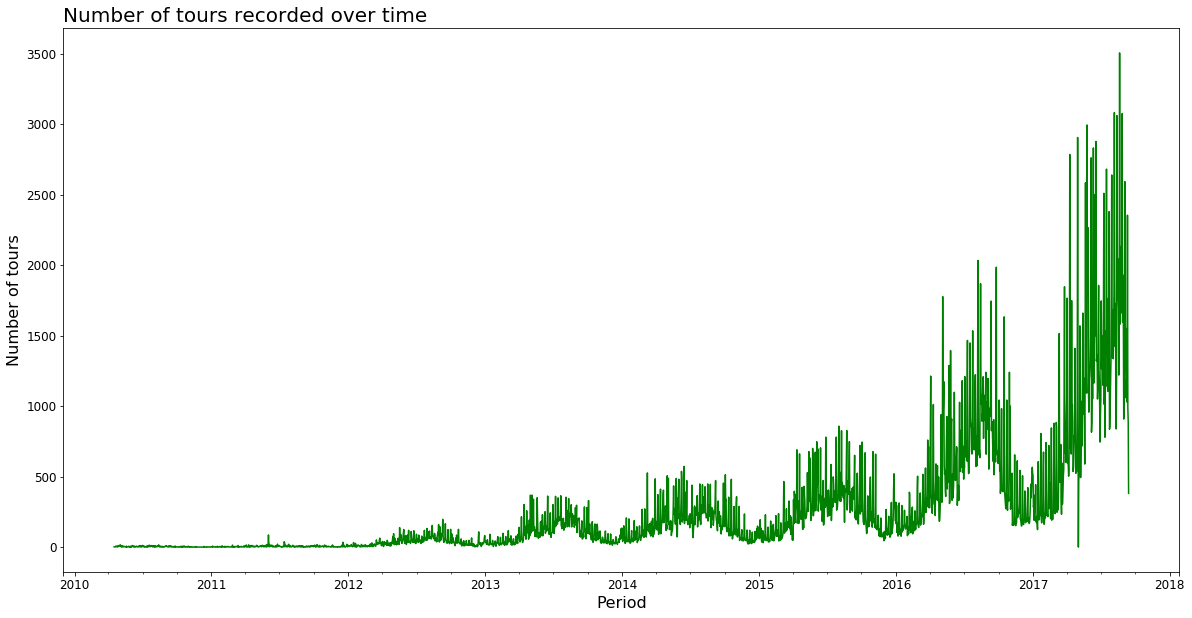

In [47]:
plt.figure(figsize=(20,10))
days_range.plot(c='g')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.title('Number of tours recorded over time', loc="left",fontsize=20)
plt.ylabel("Number of tours",fontsize=16)
plt.xlabel("Period",fontsize=16)
plt.show()

Graph above shows that number of tours recorded daily started to grow in 2012 with a boost in 2016. Seasonality is also easliy observed - it is potentially due to that most of the tours are captures in Europe (78% in Germany), so a peak in summer is self-explanatory.

In [48]:
data.drop('day',axis=1,inplace=True)

### Step six: Analyse retention rates

Assumption is that the user is from the country where he/she has the most of their trips captured. For this an auxiliary frame user_countries was created.

In [50]:
user_countries.country[~user_countries.country.isin(keep_countries)]='Other'
user_countries.country.unique()

array(['Germany', 'Switzerland', 'Other', 'Austria', 'Italy', 'France',
       'United Kingdom of Great Britain and Northern Ireland',
       'United States of America', 'Spain'], dtype=object)

In [51]:
keys=user_countries.user
values=user_countries.country
dictionary_country = dict(zip(keys, values))

In [52]:
data['user_country']=data.user.map(lambda x: dictionary_country.get(x,x))

In [53]:
print (str(len(data[data.country!=data.user_country]))+' tours were recorded in different country than the assumed home country of the user. The ratio to all tours is: '
       +str(len(data[data.country!=data.user_country])/len(data)))

74792 tours were recorded in different country than the assumed home country of the user. The ratio to all tours is: 0.11159986869199319


Create a period column - since data is from 2010 till 2017 it would be best to split by quarters and look at 30 different periods.

In [54]:
data['period']=data.timestamp.apply(lambda x: str(x.year)+'-'+'Q'+str(x.quarter))

Create an auxiliary function that counts the cohort period number for each cohort (based on hierarchical index)

In [55]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

Run the analysis

In [56]:
for c in user_countries.country.unique():
    #Copy original dataset to start each time from same source.
    df=data.copy()
    #Prepare data by limiting it to one country and adding a column with cohort (join date -> quarter) for each user.
    df=df[data.user_country==c]
    df.set_index(['user'],inplace=True)
    df['cohort']=df.groupby(level=0)['timestamp'].min().apply(lambda x: str(x.year)+'-'+'Q'+str(x.quarter))
    df.reset_index(inplace=True)
    #Create a cohorts frame of aggregated number of active users eqch quarter after starting quarter of the cohort.
    cohorts=df.groupby(['cohort', 'period']).agg({'user': pd.Series.nunique})
    #Use a function that adds a column counting number of periods any users were active from starting quarter.
    cohorts = cohorts.groupby(level=0).apply(cohort_period)
    cohorts.reset_index(inplace=True)
    #Reindex the frame to then capture the starting count of users for each cohort.
    cohorts.set_index(['cohort','cohort_period'], inplace=True)
    cohort_group_size = cohorts['user'].groupby(level=0).first()
    #Unstack the frame, keep the absolute values. Add column with total count of users for each cohort period.
    unstacked = cohorts['user'].unstack(0)
    weighted=unstacked.reset_index()
    weighted['users_total'] = weighted.drop('cohort_period', axis=1).sum(axis=1)
    #Create empty auxilliary data series, iterate over user_retention columns (cohort quarters) and populate the series
    #with average retention percentage for each row. Add the series as a column to weighted frame.
    ret_pct=pd.DataFrame(columns=['pct'])
    periods=list(unstacked.columns)
    for e in weighted.cohort_period:
        if e==1:
            ret_pct=ret_pct.append({'pct':1.0},ignore_index=True)
        else:
            ret_pct=ret_pct.append({'pct':(weighted[:e][periods].sum(axis=1)[-1:].values/weighted[:e][periods].sum(axis=1)[0])[0]},ignore_index=True)
        periods.pop()
    weighted['ret_pct'] = ret_pct['pct'].astype(float)
    #Take cohort_period and ret_pct columns from the frame, plot them and save plots as pdf.
    weighted_avg = weighted.filter(items=['cohort_period', 'ret_pct'])
    plt.figure(figsize=(20, 10))
    plt.fill_between( x=weighted_avg.cohort_period, y1=weighted_avg.ret_pct, color="green", alpha=0.3)
    plt.plot(x=weighted_avg.cohort_period, y=weighted_avg.ret_pct, color="green")
    for a,b in zip(weighted_avg.cohort_period, weighted_avg.ret_pct):
        plt.text(a, b, str(round(b,2)))

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.title(c, loc="left",fontsize=20)
    plt.ylabel("Retention rate",fontsize=16)
    plt.xlabel("Period",fontsize=16)
    plt.savefig(c+'_retention_rate.pdf')
    plt.close()
    #Plot a seaborn heatmap with absolute retention rates and save to pdf.
    plt.figure(figsize=(20, 10))
    plt.title('Cohorts: User Retention - Absolute')
    sns.heatmap(unstacked.T, mask=unstacked.T.isnull(), annot=True,fmt='g',cmap="Greens")
    plt.savefig(c+'_abs_heatmap.pdf')
    plt.close()
    #Unstack the frame, fill NaN with 0 and divide each number of users by the cohort starting count.
    user_retention=cohorts['user'].unstack(0).divide(cohort_group_size, axis=1)
    #Plot a seaborn heatmap with relative retention rates and save to pdf.
    plt.figure(figsize=(20, 10))
    plt.title('Cohorts: User Retention - %')
    sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%',cmap="Greens")
    plt.savefig(c+'_rel_heatmap.pdf')
    plt.close()